In [1]:
import torch
import numpy as np
import datasets
import pickle
import pathlib
import os
from scipy import stats
from scipy.spatial import distance
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from datasets import load_dataset
import sklearn.metrics
from WeightedCorr import WeightedCorr

globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs"
# globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs_elementwise"
models_dir = "/home/modaresi/projects/globenc_analysis/outputs/models"
configs = {
    "sst2": {
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_sst2_bert-base-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "sst2-large": {
        "globenc_path": lambda epoch : f"{globencs_dir}/sst2-e{epoch}_train_bert-large-uncased.pickle",
        "logits_path": f"{models_dir}/output_sst2_bert-large-uncased_0001_SEED0042/training_dynamics_after_step/",
        "hf_ds": "sst2",
    },
    "mnli": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    },
    "mnli-val": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mnli-e{epoch}_validation_matched.pickle",
        "logits_path": f"{models_dir}/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "mnli",
    },
    "cola": {
        "globenc_path": lambda epoch : f"{globencs_dir}/cola-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_cola_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "cola",
    },
    "mrpc": {
        "globenc_path": lambda epoch : f"{globencs_dir}/mrpc-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_mrpc_bert-base-uncased_0001_SEED0042/training_dynamics_after_step",
        "hf_ds": "mrpc",
    },
    "qnli": {
        "globenc_path": lambda epoch : f"{globencs_dir}/qnli-e{epoch}_train_bert-base-uncased.pickle",
        "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "qnli",
    },
    
    "multibert-seed-qnli": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-qnli-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "qnli",
    },
    
    "multibert-seed-sst2": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-sst2-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
    "multibert-seed-cola": {
        "globenc_path": lambda seed : f"{globencs_dir}/multibert-cola-s{seed}_train_google-multiberts-seed_0.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "cola",
    },
    "multibert-step20k-sst2": {
        "globenc_path": lambda step : f"{globencs_dir}/multibert-sst2-e{step}-20k_train_google-multiberts-seed_0-step_0k.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
    "multibert-step400k-sst2": {
        "globenc_path": lambda step : f"{globencs_dir}/multibert-sst2-e{step}-400k_train_google-multiberts-seed_0-step_0k.pickle",
#         "logits_path": f"{models_dir}/output_qnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch",
        "hf_ds": "sst2",
    },
}

CONFIG_NAME = "mnli"
CONFIG = configs[CONFIG_NAME]  # sst2/mnli/cola/mrpc

# Load globencs

In [2]:
def load_pickle(path, no_cls=False, no_sep=False):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    if no_cls:
        data["tokens"] = [d[1:] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, 1:] for d in data["globenc"]]
    if no_sep:
        data["tokens"] = [d[:-1] for d in data["tokens"]]
        data["globenc"] = [np.array(d)[:, :-1] for d in data["globenc"]]
    data = pd.DataFrame(data)
    before_size = len(data)
    data = data[data["tokens"].map(len) > 1]
    after_size = len(data)
    print(f"Read {path}: {before_size}->{after_size} ")
    return data.to_dict(orient="list"), data.index

In [3]:
globencs = list()  # [epoch, {globenc, tokens}, #]
for epoch in tqdm(range(6)):
    data, DATASET_KEEP_IDX = load_pickle(CONFIG["globenc_path"](epoch), no_cls=True, no_sep=True)
    globencs.append(data)
    
pd.DataFrame(globencs[0])

  0%|          | 0/6 [00:00<?, ?it/s]

Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e0_train_bert-base-uncased.pickle: 392702->392702 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e1_train_bert-base-uncased.pickle: 392702->392702 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e2_train_bert-base-uncased.pickle: 392702->392702 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e3_train_bert-base-uncased.pickle: 392702->392702 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e4_train_bert-base-uncased.pickle: 392702->392702 
Read /home/modaresi/projects/globenc_analysis/outputs/globencs/mnli-e5_train_bert-base-uncased.pickle: 392702->392702 


,globenc,tokens,cls
0,"[[5472449000000000.0, 4251915600000000.0, 6549...","[conceptual, ##ly, cream, ski, ##mming, has, t...","[-0.9452542, 0.12105372, -0.60921425, -0.48833..."
1,"[[5933184000000000.0, 5452533000000000.0, 6645...","[you, know, during, the, season, and, i, guess...","[-0.64641106, 0.13749051, -0.5467298, -0.08347..."
2,"[[1976973400000000.0, 1788992500000000.0, 3239...","[one, of, our, number, will, carry, out, your,...","[-0.44309825, 0.3751391, -0.65025914, -0.06511..."
3,"[[2623708000000000.0, 1724667000000000.0, 2085...","[how, do, you, know, ?, all, this, is, their, ...","[-0.20789751, 0.60683304, -0.22151911, -0.1110..."
4,"[[4442750000000000.0, 2845110600000000.0, 3393...","[yeah, i, tell, you, what, though, if, you, go...","[-0.3337493, 0.29966134, -0.5045794, -0.232158..."
...,...,...,...
392697,"[[4725140500000000.0, 2591889000000000.0, 5639...","[clearly, ,, california, can, -, and, must, -,...","[-0.64128923, 0.21204619, -0.9020296, -0.48419..."
392698,"[[2422252800000000.0, 2963870200000000.0, 3472...","[it, was, once, regarded, as, the, most, beaut...","[-0.9453015, 0.21021597, -0.252484, -0.3474131..."
392699,"[[3252803400000000.0, 5302208500000000.0, 2929...","[house, ##boats, are, a, beautifully, preserve...","[-0.5665779, 0.26888448, -0.7841134, -0.428683..."
392700,"[[3971444900000000.0, 3418852500000000.0, 6465...","[ob, ##it, ##uaries, fond, ##ly, recalled, his...","[-0.81801647, 0.21685575, -0.6798471, -0.10737..."


In [4]:
# print_globenc(globencs[0]["globenc"][0], globencs[0]["tokens"][0], prefix=f"---")
# globencs[0]["globenc"][0].shape, globencs[0]["tokens"][0]
# globencs[0]["globenc"][0].shape

# from seaborn import heatmap
# plt.figure(figsize=(14, 10))
# print(globencs[-1]["tokens"][10])
# heatmap(globencs[-1]["globenc"][10] / np.max(globencs[-1]["globenc"][10], axis=1, keepdims=True))

# Compute Corr

  0%|          | 0/392702 [00:00<?, ?it/s]

corr epoch 0 with 1: 0.8933110743190622


  0%|          | 0/392702 [00:00<?, ?it/s]

corr epoch 1 with 2: 0.9854718139821043


  0%|          | 0/392702 [00:00<?, ?it/s]

corr epoch 2 with 3: 0.9922366516488325


  0%|          | 0/392702 [00:00<?, ?it/s]

corr epoch 3 with 4: 0.9972362296495818


  0%|          | 0/392702 [00:00<?, ?it/s]

corr epoch 4 with 5: 0.999421327687415


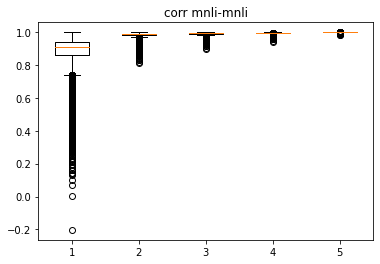

In [5]:
def compute_corr(globenc1, globenc2, corr="corr", disable_tqdm=False):
    """globenc1&2 must be [#, {globenc, token}]"""
    corrs = list()
    for i in tqdm(range(len(globenc1["globenc"])), disable=disable_tqdm):
        corrs.append(  # Last layer & CLS
            compute_corr_one(globenc1["globenc"][i][0, :], globenc2["globenc"][i][0, :], corr)
        )
    return corrs

def w_corr(x, y, w=None):
    x = np.array(x) / np.max(x); y = np.array(y) / np.max(y); 
#     w = np.array(w) / np.max(w)
    w = (x + y) ** 10
    x_bar = np.average(x, weights=w)
    y_bar = np.average(y, weights=w)
    numerator = np.sum(w*(x-x_bar)*(y-y_bar))
    denominator = np.sqrt(np.sum(w*((x-x_bar)**2)) * np.sum(w*((y-y_bar)**2)))
    return numerator / denominator

def top_k_corr(a, b, k=5):
    top_arg_a = np.flip(np.argsort(a))[:k]
    top_arg_b = np.flip(np.argsort(b))[:k]
    top_arg = np.union1d(top_arg_a, top_arg_b)
    corr = stats.pearsonr(a[top_arg], b[top_arg])[0]
#     corr = stats.spearmanr(a[top_arg], b[top_arg]).correlation
    return corr

def top_k_dist(a, b, k=5):
    top_arg_a = np.flip(np.argsort(a))[:k]
    top_arg_b = np.flip(np.argsort(b))[:k]
    top_arg = np.union1d(top_arg_a, top_arg_b)
    dist = -distance.cityblock(a[top_arg] / max(a[top_arg]), b[top_arg] / max(b[top_arg])) / len(top_arg)
    return dist

def compute_corr_one(a, b, corr):
#     corr = stats.spearmanr(globenc1[i]["globenc"][-1, 0, :], globenc2[i]["globenc"][-1, 0, :]).correlation
    if corr == "corr":
        corr = stats.pearsonr(a, b)[0]
    if corr == "w_corr":
        corr = w_corr(a, b)
    if corr == "top_k_corr":
        corr = top_k_corr(a, b)
    if corr == "top_k_dist":
        corr = top_k_dist(a, b)
    if corr == "jensenshannon":
        return -distance.jensenshannon(a, b)
#     corr = stats.kendalltau(a, b)[0]
    return corr

CORR = "corr"
all_corrs = []
for epoch in range(len(globencs) - 1):
    corr = compute_corr(globencs[epoch], globencs[epoch + 1], CORR)
    all_corrs.append(corr)
    print(f"{CORR} epoch {epoch} with {epoch+1}: {np.mean(corr)}")
plt.boxplot(all_corrs)
plt.title(f"{CORR} {CONFIG['hf_ds']}-{CONFIG_NAME}")
plt.show()
# print(np.argsort(s)[:20], "\n", np.argsort(s)[-20:])

# Visualize

In [7]:
def plot_globenc(globenc, tokenized_text):
    plt.figure(figsize=(10, 5))
    norm_cls = globenc[:, 0, :]
    norm_cls = np.flip(norm_cls, axis=0)
    row_sums = norm_cls.max(axis=1)
    norm_cls = norm_cls / row_sums[:, np.newaxis]
    df = pd.DataFrame(norm_cls, columns=tokenized_text, index=range(len(norm_cls), 0, -1))
    ax = sns.heatmap(df, cmap="Reds", square=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("GlobEnc", fontsize=16)
    plt.ylabel("Layer", fontsize=16)
    plt.xticks(rotation = 90, fontsize=16)
    plt.yticks(fontsize=13)
    plt.gcf().subplots_adjust(bottom=0.2)

def print_globenc(globenc, tokenized_text, discrete=False, prefix="", no_cls=False):
    if len(globenc.shape) == 2:
        globenc = np.expand_dims(globenc, axis=0)
    norm_cls = globenc[:, 0, :]
    norm_cls = np.flip(norm_cls, axis=0)
    row_sums = norm_cls.max(axis=1)
    norm_cls = norm_cls / row_sums[:, np.newaxis]
    html = prefix
    if discrete:
        cls_attention = np.argsort(np.argsort(norm_cls[0, :])) / len(norm_cls[0, :])
    else:
        cls_attention = norm_cls[0, :]
    for i in range(len(tokenized_text)):
        html += (f"<span style='"
                 f"background-color: rgba({cls_attention[i]*255}, {cls_attention[i]*255}, 0, {cls_attention[i] / 1.5}); "
#                  f"background-color: rgba(200, {cls_attention[i]*255}, 10, 1.0); "
#                  f"font-size: {int(cls_attention[i]*18 + 1)}px; "
#                  f"font-weight: {int(cls_attention[i]*900)};"
                 f"font-weight: {int(800)};"
                 "'>")
        html += tokenized_text[i]
        html += "</span> "
    display(HTML(html))

print(CORR)
# corr = compute_corr(globencs[0], globencs[-1], CORR)
for idx in np.argsort(corr)[:20]:
    idx = 24638
    print("idx:", idx, "corr:", corr[idx])
    for i in range(6):
    #     plot_globenc(globencs[i][idx]["globenc"], globencs[i][idx]["tokens"])
        print_globenc(globencs[i]["globenc"][idx], globencs[i]["tokens"][idx], prefix=f"Epoch {i}: ", no_cls=True)

corr
idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


idx: 24638 corr: 0.9994884929826603


In [ ]:
display(HTML("<span style='background-color: rgba(255, 50, 50, 0.5)'>This text is highlighted in yellow.</span>"))

# CLS Analysis

  0%|          | 0/392702 [00:00<?, ?it/s]

cos_sim epoch 0 with 1: 0.36061668395996094


  0%|          | 0/392702 [00:00<?, ?it/s]

cos_sim epoch 1 with 2: 0.9059139490127563


  0%|          | 0/392702 [00:00<?, ?it/s]

cos_sim epoch 2 with 3: 0.9454773664474487


  0%|          | 0/392702 [00:00<?, ?it/s]

cos_sim epoch 3 with 4: 0.9176584482192993


  0%|          | 0/392702 [00:00<?, ?it/s]

cos_sim epoch 4 with 5: 0.9591631889343262


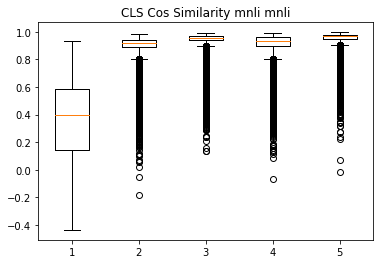

In [7]:
def compute_cosine_similarity(globenc1, globenc2):
    cos = list()
    for i in tqdm(range(len(globenc1["cls"]))):
        cos.append(
            sklearn.metrics.pairwise.cosine_similarity([globenc1["cls"][i]], [globenc2["cls"][i]])[0][0]
#             np.mean(np.abs(globenc1["cls"][i] - globenc2["cls"][i]))
        )
    return cos

all_cos_sims = []
for epoch in range(len(globencs) - 1):
    cos_sim = compute_cosine_similarity(globencs[epoch], globencs[epoch + 1])
    all_cos_sims.append(cos_sim)
    print(f"cos_sim epoch {epoch} with {epoch+1}: {np.mean(cos_sim)}")
    
plt.boxplot(all_cos_sims)
plt.title(f"CLS Cos Similarity {CONFIG_NAME} {CONFIG['hf_ds']}")
plt.show()

corr: 0.28827426191809274
corr: 0.059975634891074645
corr: 0.08984797266436752
corr: 0.05060061705768033
corr: 0.21448242165469356


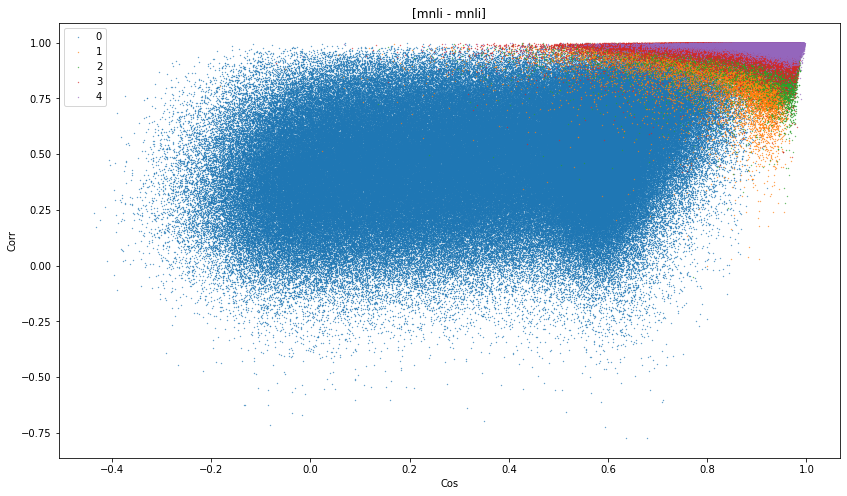

In [19]:
plt.figure(figsize=(14, 8))
for i in range(len(all_corrs)):
    plt.scatter(all_cos_sims[i], all_corrs[i], s=0.1, label=i)
    print("corr:", stats.pearsonr(all_cos_sims[i], all_corrs[i])[0])
plt.title(f"[{CONFIG_NAME} - {CONFIG['hf_ds']}]")
plt.xlabel("Cos"); plt.ylabel("Corr")
# plt.ylim(0.85);
# plt.xlim(0.3); 
plt.legend()
plt.show()

# Cartography

In [20]:
def load_logits(dir_path: str):
    file_list = os.listdir(dir_path)
    file_list.sort()
    print("Loading files in:", dir_path)
    idxs, logits = [], []
    for file_name in file_list:
        print(file_name)
        file_path = f"{dir_path}/{file_name}"
        if "idxs" in file_path:
            idxs.append(np.array(torch.load(file_path)))
        elif "logits" in file_path:
            logits.append(np.array(torch.load(file_path)))
        else:
            raise Exception("Wrong Files!")
    logits_ordered = np.zeros(np.array(logits).shape)
    print(max(idxs[0]))
    for epoch in range(len(idxs)):
        logits_ordered[epoch][idxs[epoch]] = logits[epoch]
    return logits_ordered

def el2n(logits, labels):
    logits = torch.tensor(logits)  # (3, 392702, 3)
    labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=max(labels) + 1)  # (392702, 3)
    scores = []
    for epoch in range(len(logits)):
        errors = torch.nn.functional.softmax(logits[epoch], dim=-1) - labels
#         score = torch.linalg.vector_norm(errors, dim=-1, ord=2)
        score = np.linalg.norm(errors, ord=2, axis=-1)
        scores.append(score)
    return np.mean(np.array(scores), axis=0)

def cartography(logits, true_labels):
    probs = torch.nn.functional.softmax(logits, dim=-1).numpy()
    corr_probs = np.sum(probs * np.expand_dims(torch.nn.functional.one_hot(true_labels, num_classes=max(true_labels) + 1).numpy(), axis=0), axis=-1)
    confs = np.mean(corr_probs, axis=0)
    variabilities = np.std(corr_probs, axis=0)
    return confs, variabilities

In [21]:
logits = load_logits(CONFIG["logits_path"])
logits.shape

Loading files in: /home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/training_dynamics_after_epoch
epoch0_step012272_after_epoch_train_idxs_[392702].pt
epoch0_step012272_after_epoch_train_logits_[392702, 3].pt
epoch1_step024544_after_epoch_train_idxs_[392702].pt
epoch1_step024544_after_epoch_train_logits_[392702, 3].pt
epoch2_step036816_after_epoch_train_idxs_[392702].pt
epoch2_step036816_after_epoch_train_logits_[392702, 3].pt
epoch3_step049088_after_epoch_train_idxs_[392702].pt
epoch3_step049088_after_epoch_train_logits_[392702, 3].pt
epoch4_step061360_after_epoch_train_idxs_[392702].pt
epoch4_step061360_after_epoch_train_logits_[392702, 3].pt
392701


(5, 392702, 3)

In [22]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
ds = ds.select(indices=DATASET_KEEP_IDX)
logits = [l[DATASET_KEEP_IDX] for l in logits]
confs, vars = cartography(torch.tensor(logits), torch.tensor(ds['label']))

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


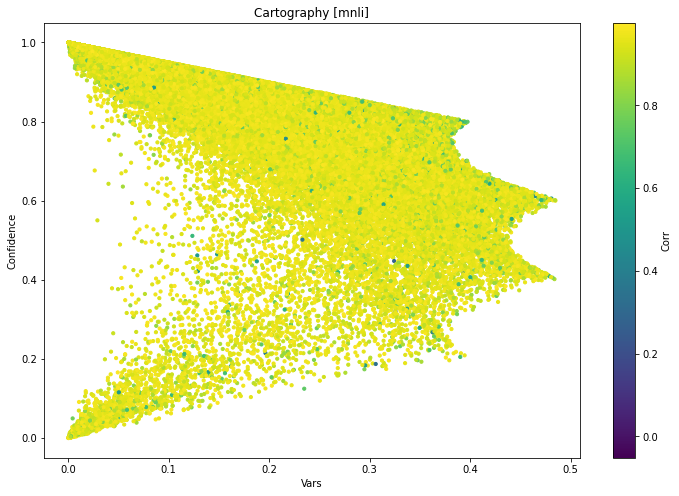

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(vars, confs, s=10, c=np.min(np.array(all_corrs)[1:, :], axis=0))
plt.xlabel("Vars")
plt.ylabel("Confidence")
plt.title(f"Cartography [{CONFIG['hf_ds']}]")
plt.colorbar(label="Corr")

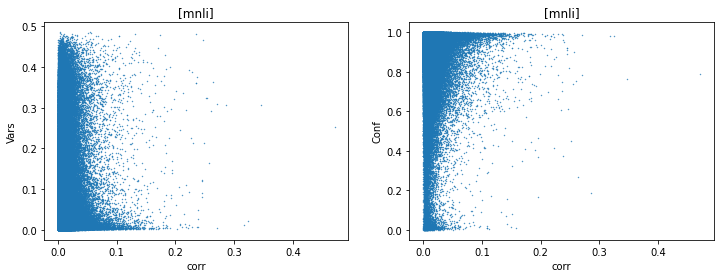

In [36]:
# corr = compute_corr(globencs[0], globencs[-1], CORR)
corr = np.std(np.array(all_corrs)[2:, :], axis=0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(corr, vars, s=.15)
plt.title(f"[{CONFIG['hf_ds']}]")
plt.xlabel(CORR)
plt.ylabel("Vars")

plt.subplot(1, 2, 2)
plt.scatter(corr, confs, s=.15)
plt.title(f"[{CONFIG['hf_ds']}]")
plt.xlabel(CORR)
plt.ylabel("Conf")
plt.show()

In [ ]:
def torch_pearson(x1, x2): # 1D tensor, 1D tensor -> scalar (Pearson Correlation)
    m1 = x1.mean()
    m2 = x2.mean()
    d1 = x1 - m1
    d2 = x2 - m2
    Cxy = torch.sum(d1*d2)
    Cxx = torch.sum(d1*d1)
    Cyy = torch.sum(d2*d2)
    return Cxy/(Cxx*Cyy).sqrt()

def calc_pRSA(i, v1, v2): # Calculates pointwise RSA [index, Vectorspace1, Vectorspace2]
    mask = ~torch.nn.functional.one_hot(torch.tensor(i), v1.shape[0]).bool()
    sims_e0 = torch.nn.functional.cosine_similarity(v1[mask], v1[i], dim=1, eps=1e-08)
    sims_e1 = torch.nn.functional.cosine_similarity(v2[mask], v2[i], dim=1, eps=1e-08)
    return torch_pearson(sims_e0, sims_e1).cpu()

print("GPU...")
all_cls = [torch.tensor(globencs[i]["cls"]).cuda() for i in range(len(globencs))]
print("GPU Done")

# sort_var = np.argsort(all_cos_sims[0] + all_corrs[0])[0: 50]
sort_var = np.flip(np.argsort(vars))[10: 12]
# sort_var = np.argsort(all_corrs[3])[0:10]
for idx in sort_var:
    print(f"### {idx} ###")
    for i in range(6):
        print_globenc(globencs[i]["globenc"][idx], globencs[i]["tokens"][idx], prefix=f"Epoch {i}: ")
        if i < 5:
            print(f"(conf {confs[idx]:0.4f}) | (var {vars[idx]:0.4f}) |",
                  f"(logit {logits[i][idx]}) | (label {ds['label'][idx]}) | ",
                  f"(corr {i}->{i+1} {compute_corr_one(globencs[i]['globenc'][idx][0, :], globencs[i+1]['globenc'][idx][0, :], CORR):0.4f})",
                  f"(cos {i}->{i+1} {all_cos_sims[i][idx]:0.4f})",
                  f"(pRSA {i}->{i+1} {calc_pRSA(idx, all_cls[i], all_cls[i+1]).cpu():0.4f})"
                 )

GPU
### 192454 ###


(conf 0.4093) | (var 0.4789) | (logit [-0.99192446  3.68825221 -2.94573498]) | (label 0) |  (corr 0->1 0.6075) (cos 0->1 0.1665) (pRSA 0->1 -0.0031765680760145187)


(conf 0.4093) | (var 0.4789) | (logit [-0.27099669  3.63244891 -3.63229418]) | (label 0) |  (corr 1->2 0.9805) (cos 1->2 0.9470) (pRSA 1->2 0.9114178419113159)


(conf 0.4093) | (var 0.4789) | (logit [-0.09073719  3.54002738 -3.66527247]) | (label 0) |  (corr 2->3 0.9867) (cos 2->3 0.9457) (pRSA 2->3 0.9485160708427429)


(conf 0.4093) | (var 0.4789) | (logit [ 4.33266687 -0.70312941 -3.96239376]) | (label 0) |  (corr 3->4 0.6199) (cos 3->4 0.3955) (pRSA 3->4 0.2780570387840271)


(conf 0.4093) | (var 0.4789) | (logit [ 4.99834156 -1.49295461 -3.91323423]) | (label 0) |  (corr 4->5 0.9899) (cos 4->5 0.9512) (pRSA 4->5 0.9811353087425232)


### 161786 ###


(conf 0.6038) | (var 0.4784) | (logit [ 2.24414206 -0.6626066  -1.93934858]) | (label 2) |  (corr 0->1 0.5744) (cos 0->1 0.6751) (pRSA 0->1 0.08479537814855576)


(conf 0.6038) | (var 0.4784) | (logit [ 2.16792488 -0.71663529 -1.59061921]) | (label 2) |  (corr 1->2 0.9463) (cos 1->2 0.9500) (pRSA 1->2 0.903372049331665)


# Scatter [corr/cos vs length/label]

  0%|          | 0/392702 [00:00<?, ?it/s]

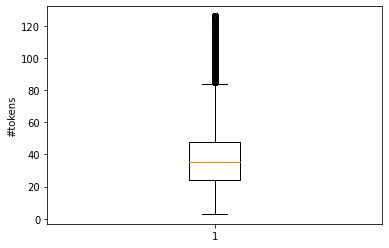

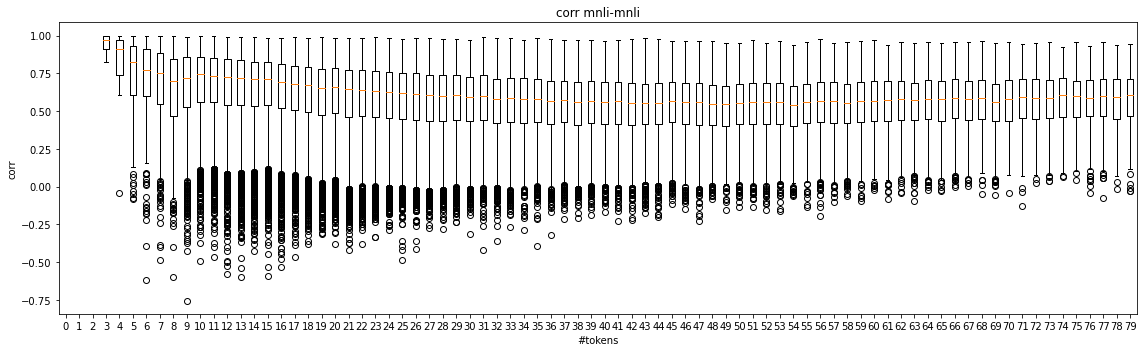

NameError: name 'cls_cos' is not defined

In [27]:
g_corr = compute_corr(globencs[0], globencs[-1], CORR)
# cls_cos = compute_cosine_similarity(globencs[0], globencs[-1])

plt.boxplot([len(x) for x in globencs[0]["tokens"]])
plt.ylabel("#tokens")
plt.show()

plt.figure(figsize=(16, 5))
# plt.subplot(1, 2, 1)
# plt.scatter([len(x) for x in globencs[0]["tokens"]], g_corr, s=2, alpha=0.01)
lens = np.array([len(x) for x in globencs[0]["tokens"]])
bucket_corr = {l: np.array(g_corr)[(lens == l)] for l in range(0, 80)}
plt.boxplot(bucket_corr.values(), labels=bucket_corr.keys(), showfliers=True)
plt.title(f"{CORR} {CONFIG['hf_ds']}-{CONFIG_NAME}")
plt.ylabel(CORR)
plt.xlabel("#tokens")
plt.tight_layout()
plt.show()

# plt.subplot(1, 2, 2)
plt.scatter([len(x) for x in globencs[0]["tokens"]], cls_cos, s=1)
plt.ylabel("cls cos")
plt.xlabel("#tokens")
plt.tight_layout()
plt.show()

# ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
# print(len(g_corr), len(ds['label']))
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# df = pd.DataFrame({"g_corr": g_corr, "label": ds['label']})
# df.boxplot(by='label', ax=plt.gca())
# plt.subplot(1, 2, 2)

# df = pd.DataFrame({"cls cos": cls_cos, "label": ds['label']})
# df.boxplot(by='label', ax=plt.gca())
# plt.tight_layout()

# Playground

In [ ]:
ds[0]

In [ ]:
globencs[0]["tokens"][0]

In [ ]:
ds = load_dataset("glue", CONFIG["hf_ds"], split="train")
sns.violinplot()